## Simple MULTI AI Agent Architecture

In [1]:
import os
from typing import TypedDict, Annotated, List, Literal
from langchain_core.messages import BaseMessage, AIMessage, SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool  
from langchain_community.tools.tavily_search import TavilySearchResults 
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver


In [2]:
import os 
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [3]:
from langgraph.graph import StateGraph, END,MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [4]:
#Define the State
class AgentState(MessagesState):
    next_agent:str #which agent should go next

In [5]:
#Sample Tool
@tool
def search_web(query:str)->str:
    """Search the web for information. """
    #using tavily for web search 
    search=TavilySearchResults(max_result=3)
    results=search.invoke(query)
    return str(results)


@tool
def write_summary(content:str)->str:
    """ write a sumary of the porvuded content."""
    #3 simple summary generation
    summary=f"sumary of findings:\n\n{content[:500]}..."
    return summary

In [6]:
 from langchain.chat_models import init_chat_model
 llm=init_chat_model("groq:llama-3.1-8b-instant")
 llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000158A6568AD0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000158A65696A0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
 ## Defining the Researcher Funtions(Simpler Approach)
 def researcher_agent(state:AgentState):
    """Researcher agent that searcher for information"""
    messages=state["messages"]
    ##Add system message for content
    system_msg=SystemMessage(content="You are a research assistant.Use the search_web tool for information about the user's request")
    # Call LLM with Tools
    researcher_llm=llm.bind_tools([search_web])
    response=researcher_llm.invoke([system_msg]+messages)
    #return the respose and route to writer
    return {
        "messages":[response],
        "next_agent":"writer"
    }

In [8]:
def writer_agent(state:AgentState):
    """Writer agent that creates summaries"""
    messages=state["messages"]
    # Add system message
    system_msg=SystemMessage(content="You are a technical writter.Review the conversation and create a clear,concise summary of the findings")
    # simple compleion without tools
    response=llm.invoke([system_msg]+messages)
    return{
        "messages":[response],
        "next_agent":"end"
    }

In [9]:
# Tool Executer Node
def execute_tools(state:AgentState):
    """ Execute any pending tool calls"""
    messages=state["messages"]
    last_message=messages[-1]
    #check if there are tool calls to execute
    if hasattr(last_message,"tool_calls")and last_message.tool_calls:
        #craete tool node and execute
        tool_node=ToolNode([search_web,write_summary])
        response=tool_node.invoke(state)
        return response


        # no tools to execute
        return state

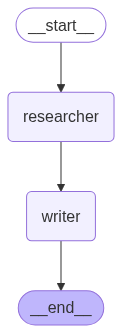

In [10]:
#Build grpah
workflow=StateGraph(MessagesState)
# Add nodes
workflow.add_node("researcher",researcher_agent)
workflow.add_node("writer",writer_agent)

# Define Flow
workflow.set_entry_point("researcher")
workflow.add_edge("researcher","writer")
workflow.add_edge("writer",END)
final_workflow=workflow.compile()
print(final_workflow)
final_workflow

In [11]:
final_workflow.invoke({
    "messages": [
        {"role": "user", "content": "Research about the usage of agentic ai in business"}
    ]
})


{'messages': [HumanMessage(content='Research about the usage of agentic ai in business', additional_kwargs={}, response_metadata={}, id='bdde59b0-6828-4b8c-a9e1-cc70f6ca3060'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '0vbmthcwf', 'function': {'arguments': '{"query":"agentic AI in business usage"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 237, 'total_tokens': 256, 'completion_time': 0.03229645, 'prompt_time': 0.014078492, 'queue_time': 0.048473737, 'total_time': 0.046374942}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--72678d0d-b329-4aaa-9785-f85d4413db0d-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'agentic AI in business usage'}, 'id': '0vbmthcwf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 237, 'output_tokens': 19, 'total_tokens': 256}

In [12]:
final_workflow.invoke({"messages":"Research about the tools and technolgies apple company is using"})

{'messages': [HumanMessage(content='Research about the tools and technolgies apple company is using', additional_kwargs={}, response_metadata={}, id='fd3e5164-c27e-4943-9c31-716e6639cfe7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fx7pw93fm', 'function': {'arguments': '{"query":"Apple company tools and technologies"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 239, 'total_tokens': 257, 'completion_time': 0.031597423, 'prompt_time': 0.014129743, 'queue_time': 0.049235717, 'total_time': 0.045727166}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8ab2e50475', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d3b2095c-9b6d-4eec-bba4-d4b06334baa5-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'Apple company tools and technologies'}, 'id': 'fx7pw93fm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 239, 'output_tok

In [13]:
response=final_workflow.invoke({"messages":"Research about the tools and technolgies apple company is using"})

In [14]:
response["messages"][-1].content

" \n\nBased on the research, Apple company is utilizing a wide range of cutting-edge tools and technologies across various departments. Here's a summary:\n\n**Hardware:**\n\n1. **M1 Chip:** Apple's M1 chip is a system-on-a-chip (SoC) designed in-house, combining CPU, GPU, and Neural Engine capabilities. It powers Apple's latest Mac lineup, offering improved performance, power efficiency, and security.\n2. **ARM Architecture:** Apple's transition to ARM-based processors for their Mac lineup, using the M1 chip, provides a more efficient and secure architecture.\n3. **Retina Displays:** Apple's Retina displays offer high-resolution visuals, with technologies like True Tone and P3 color gamut for enhanced color accuracy and viewing experiences.\n\n**Software:**\n\n1. **iOS and iPadOS:** Apple's mobile operating systems, iOS and iPadOS, provide a seamless user experience, with features like Face ID, Touch ID, and Siri.\n2. **macOS:** Apple's desktop operating system, macOS, offers a robust 